# Assignment 4

## Imports

In [1]:
import os
from typing import Literal

import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from matplotlib.axes import Axes

## Constants

In [2]:
PROJECT_DIR = '..'
IMAGES_DIR = os.path.join(PROJECT_DIR, 'images')
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'src/output')
PLOTS_DIR = os.path.join(PROJECT_DIR, 'src/plots')

## Helper Functions

In [3]:
def read_image(src_path: str, color_space: Literal['rgb', 'gray', 'alpha'] = 'rgb') -> npt.NDArray[np.uint8]:
    """ Reads an image into an array, given the absolute path. """

    if color_space == 'rgb':
        image = cv2.imread(src_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == 'gray':
        image = cv2.imread(src_path, 0)
    elif color_space == 'alpha':
        image = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
        _, _, _, image = cv2.split(image)
    else:
        raise ValueError(f'Unrecognised color space argument {color_space}')
    return image

In [4]:
def write_image(dest_path: str, image: npt.NDArray[np.uint8]) -> None:
    """ Writes an array as an image file, given the absolute path. """

    if image.ndim == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dest_path, image_bgr)
    else:
        cv2.imwrite(dest_path, image)

In [5]:
def display_image(image: npt.NDArray[np.uint8], title: str = '', ax: Axes = None) -> None:
    """ Displays the image represented by an array. """

    if ax is None:
        if image.ndim == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    else:
        if image.ndim == 3:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

In [6]:
def save_plot(dest_path: str) -> None:
    """ Saves the plot as an image file, given the absolute path. """

    plt.savefig(dest_path, bbox_inches='tight')

## Questions

### Question 1

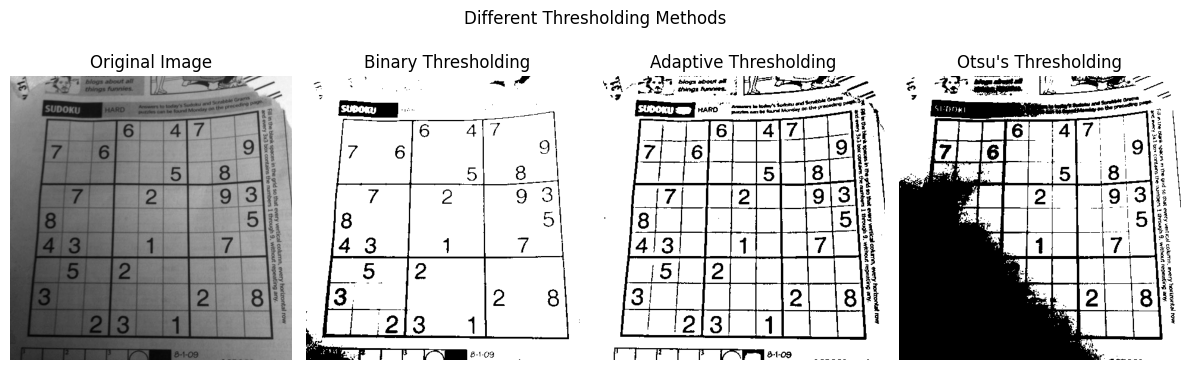

In [7]:
sudoko = read_image(f'{IMAGES_DIR}/sudoku.jpg', color_space='gray')
_, sudoko_binary = cv2.threshold(sudoko, 50, 255, cv2.THRESH_BINARY)
sudoko_adaptive = cv2.adaptiveThreshold(sudoko, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 10)
_, sudoko_otsu = cv2.threshold(sudoko, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

write_image(f'{OUTPUT_DIR}/sudoko_binary.png', sudoko_binary)
write_image(f'{OUTPUT_DIR}/sudoko_adaptive.png', sudoko_adaptive)
write_image(f'{OUTPUT_DIR}/sudoko_otsu.png', sudoko_otsu)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Different Thresholding Methods')

display_image(sudoko, 'Original Image', axs[0])
display_image(sudoko_binary, 'Binary Thresholding', axs[1])
display_image(sudoko_adaptive, 'Adaptive Thresholding', axs[2])
display_image(sudoko_otsu, 'Otsu\'s Thresholding', axs[3])

plt.tight_layout()
save_plot(f'{PLOTS_DIR}/thresholding_methods.png')

**Observations:**

Difference in lighting is evident across the input image. Global thresholding methods (such as Binary and Otsu's) are prone to failure in such cases, while local/adaptive thresholding tend to perform better as similar illumination can be ensured by adjusting the local neighbourhood size.

### Question 2

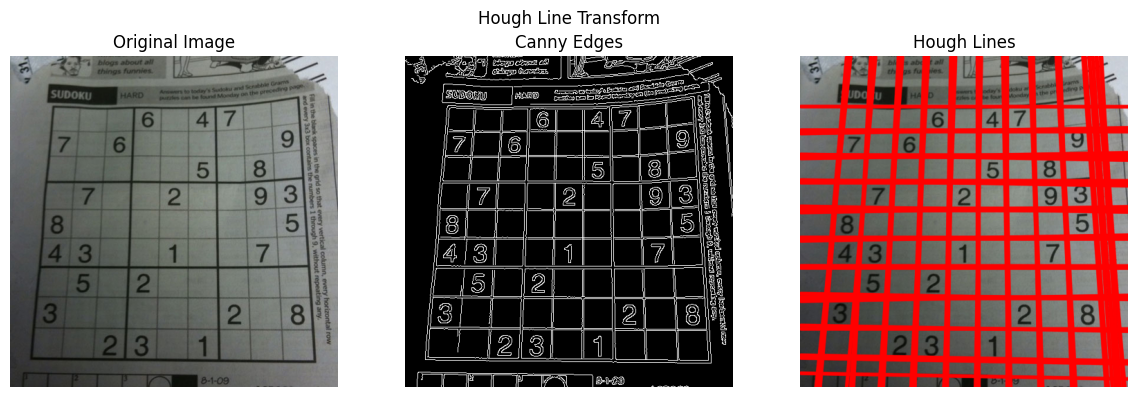

In [8]:
def plot_straight_lines(img: npt.NDArray[np.uint8], lines: npt.NDArray[float]) -> npt.NDArray[np.uint8]:
    """ Plots straight lines onto an image. """

    img_lines = img.copy()
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(img_lines, pt1, pt2, (255, 0, 0), 3, cv2.LINE_AA)
    return img_lines

def detect_straight_lines(img: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """ Detect and highlight straight lines using the Hough Line Transform. """

    # Edge detection
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_edges = cv2.Canny(img_gray, threshold1=50, threshold2=100)

    # Straight line detection
    lines = cv2.HoughLines(img_edges, rho=1, theta=np.pi/180, threshold=150)

    # Highlight straight lines
    img_lines = plot_straight_lines(img, lines)

    # Plot transformations
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle('Hough Line Transform')

    display_image(img, 'Original Image', axs[0])
    display_image(img_edges, 'Canny Edges', axs[1])
    display_image(img_lines, 'Hough Lines', axs[2])

    plt.tight_layout()
    save_plot(f'{PLOTS_DIR}/hough_line_transform.png')

    return img_lines

sudoku = read_image(f'{IMAGES_DIR}/sudoku.jpg')
sudoku_lines = detect_straight_lines(sudoku)
write_image(f'{OUTPUT_DIR}/sudoku.png', sudoku_lines)

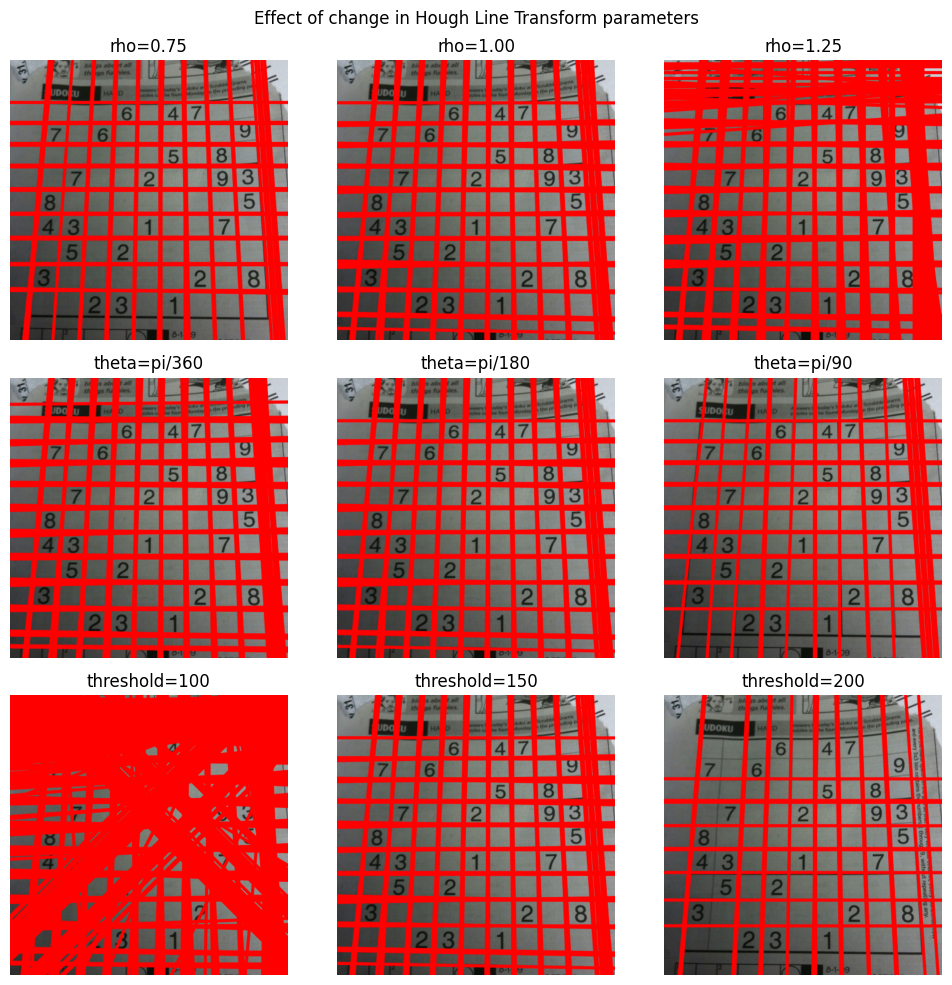

In [9]:
sudoku = read_image(f'{IMAGES_DIR}/sudoku.jpg')
sudoku_gray = cv2.cvtColor(sudoku, cv2.COLOR_RGB2GRAY)
sudoku_edges = cv2.Canny(sudoku_gray, threshold1=50, threshold2=100)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Effect of change in Hough Line Transform parameters')

display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=0.75, theta=np.pi/180, threshold=150)), 'rho=0.75', axs[0][0])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1.00, theta=np.pi/180, threshold=150)), 'rho=1.00', axs[0][1])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1.25, theta=np.pi/180, threshold=150)), 'rho=1.25', axs[0][2])

display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/360, threshold=150)), 'theta=pi/360', axs[1][0])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/180, threshold=150)), 'theta=pi/180', axs[1][1])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/90, threshold=150)), 'theta=pi/90', axs[1][2])

display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/180, threshold=100)), 'threshold=100', axs[2][0])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/180, threshold=150)), 'threshold=150', axs[2][1])
display_image(plot_straight_lines(sudoku, cv2.HoughLines(sudoku_edges, rho=1, theta=np.pi/180, threshold=200)), 'threshold=200', axs[2][2])

plt.tight_layout()
save_plot(f'{PLOTS_DIR}/hough_line_transform_parameters.png')

**Observations:**

- More lines were captured for lower values of threshold and theta, and higher values of rho.

- This can be interpreted as increase in recall, and decrease in precision.

- There are also min and max theta parameters but the slope of detected lines are already in line with our expectations, and hence they need not be in taken into consideration.

### Question 3

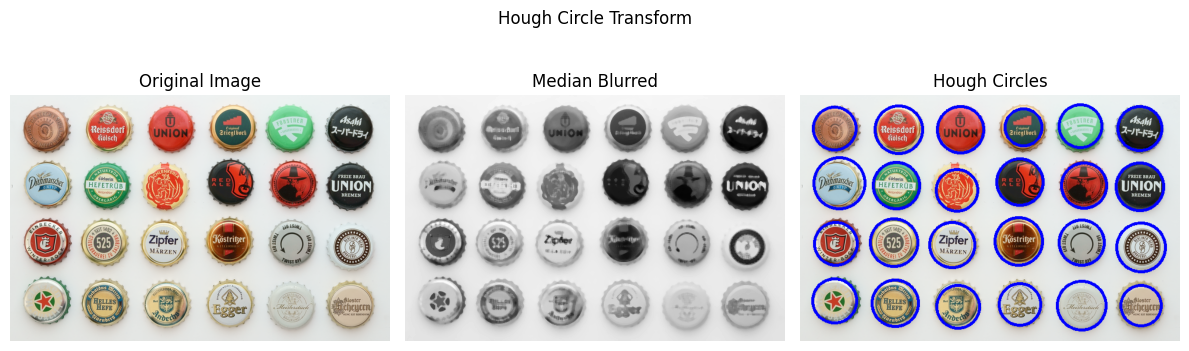

In [10]:
def plot_circles(img: npt.NDArray[np.uint8], circles: npt.NDArray[float]) -> npt.NDArray[np.uint8]:
    """ Plots circles onto an image. """

    img_circles = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cv2.circle(img_circles, center, radius, (0, 0, 255), 3)
    return img_circles

def detect_circles(img: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """ Detect and highlight straight lines using the Hough Circle Transform. """

    # Blur
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_blurred = cv2.medianBlur(img_gray, 5)

    # Circle detection
    circles = cv2.HoughCircles(img_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)

    # Highlight circles
    img_circles = plot_circles(img, circles)

    # Plot transformations
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle('Hough Circle Transform')

    display_image(img, 'Original Image', axs[0])
    display_image(img_blurred, 'Median Blurred', axs[1])
    display_image(img_circles, 'Hough Circles', axs[2])

    plt.tight_layout()
    save_plot(f'{PLOTS_DIR}/hough_circle_transform.png')

    return img_circles

caps = read_image(f'{IMAGES_DIR}/caps.png')
caps_circles = detect_circles(caps)
write_image(f'{OUTPUT_DIR}/caps.png', caps_circles)

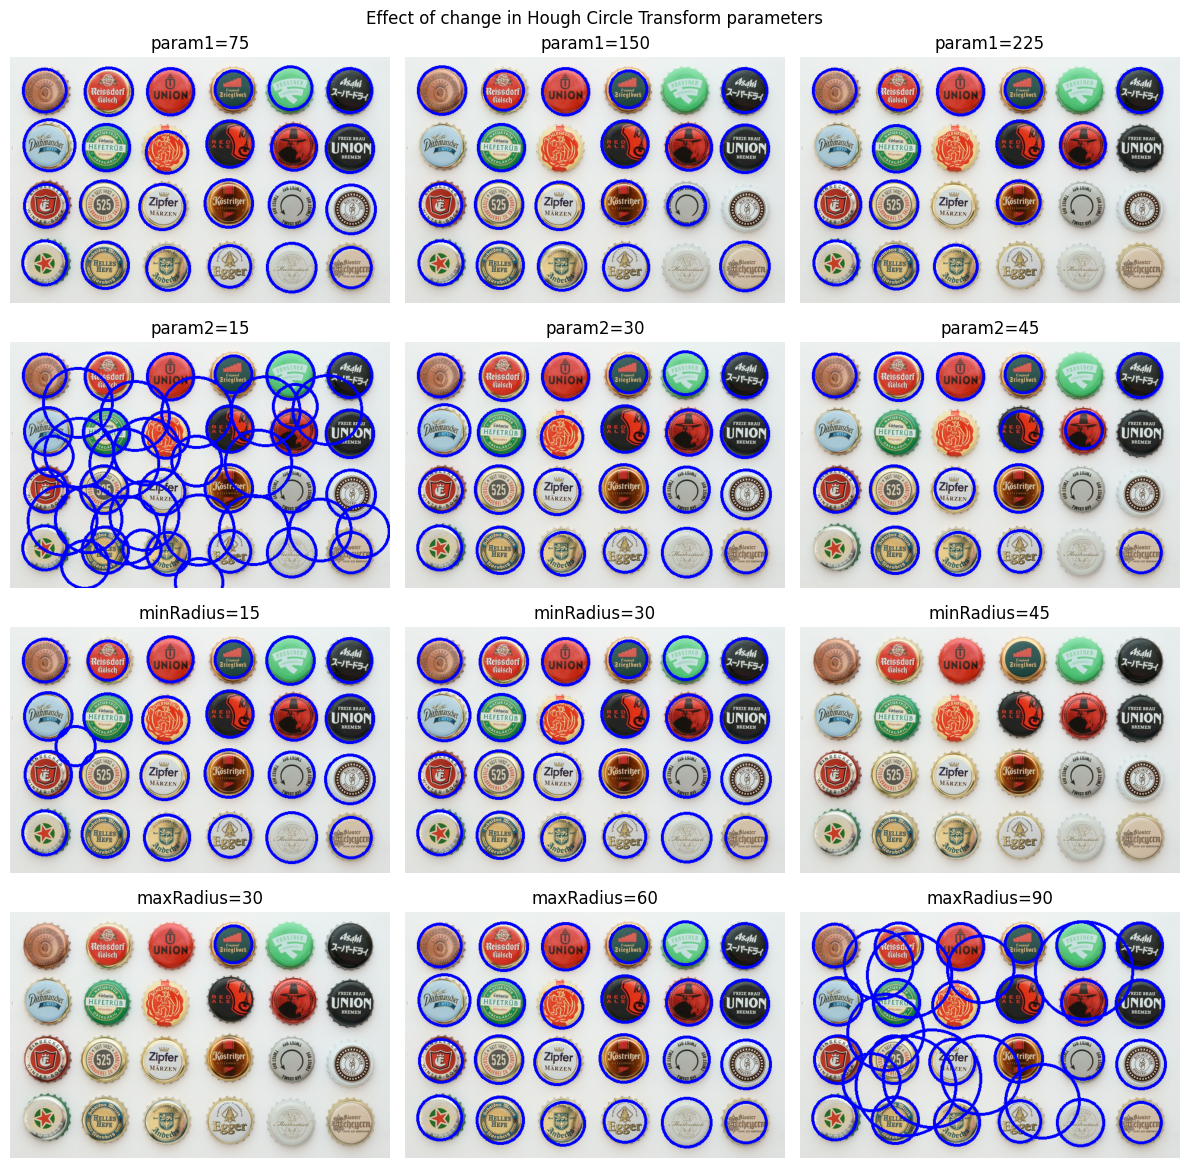

In [11]:
caps = read_image(f'{IMAGES_DIR}/caps.png')
caps_gray = cv2.cvtColor(caps, cv2.COLOR_RGB2GRAY)
caps_blurred = cv2.medianBlur(caps_gray, 5)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
fig.suptitle('Effect of change in Hough Circle Transform parameters')

display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)), 'param1=75', axs[0][0])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=150, param2=30, minRadius=30, maxRadius=60)), 'param1=150', axs[0][1])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=225, param2=30, minRadius=30, maxRadius=60)), 'param1=225', axs[0][2])

display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=15, minRadius=30, maxRadius=60)), 'param2=15', axs[1][0])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)), 'param2=30', axs[1][1])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=45, minRadius=30, maxRadius=60)), 'param2=45', axs[1][2])

display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=15, maxRadius=60)), 'minRadius=15', axs[2][0])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)), 'minRadius=30', axs[2][1])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=45, maxRadius=60)), 'minRadius=45', axs[2][2])

display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=30)), 'maxRadius=30', axs[3][0])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)), 'maxRadius=60', axs[3][1])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=90)), 'maxRadius=90', axs[3][2])

plt.tight_layout()
save_plot(f'{PLOTS_DIR}/hough_circle_transform_parameters.png')

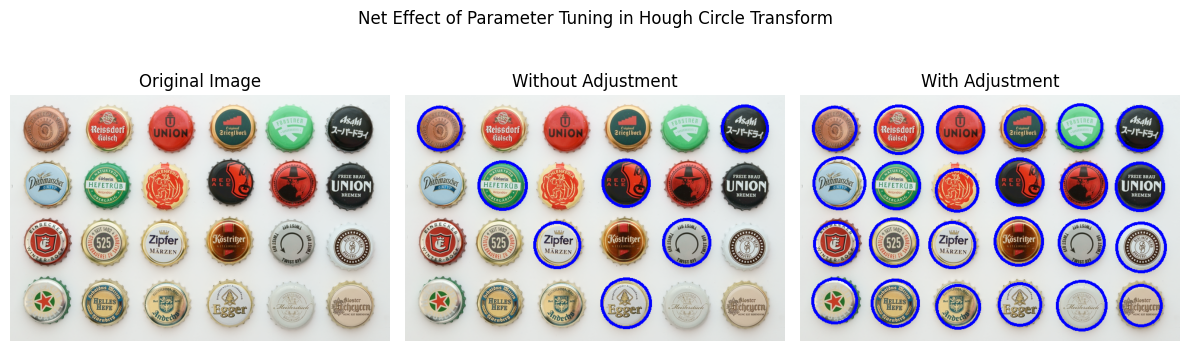

In [12]:
caps = read_image(f'{IMAGES_DIR}/caps.png')
caps_gray = cv2.cvtColor(caps, cv2.COLOR_RGB2GRAY)
caps_blurred = cv2.medianBlur(caps_gray, 5)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Net Effect of Parameter Tuning in Hough Circle Transform')

display_image(caps, 'Original Image', axs[0])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40)), 'Without Adjustment', axs[1])
display_image(plot_circles(caps, cv2.HoughCircles(caps_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=40, param1=75, param2=30, minRadius=30, maxRadius=60)), 'With Adjustment', axs[2])

plt.tight_layout()
save_plot(f'{PLOTS_DIR}/hough_circle_transform_before_after.png')

**Observations:**

- More circles were captured for lower values of param1, param2 and minRadius, and higher values of maxRadius.

- This can be interpreted as increase in recall, and decrease in precision.

### Question 4

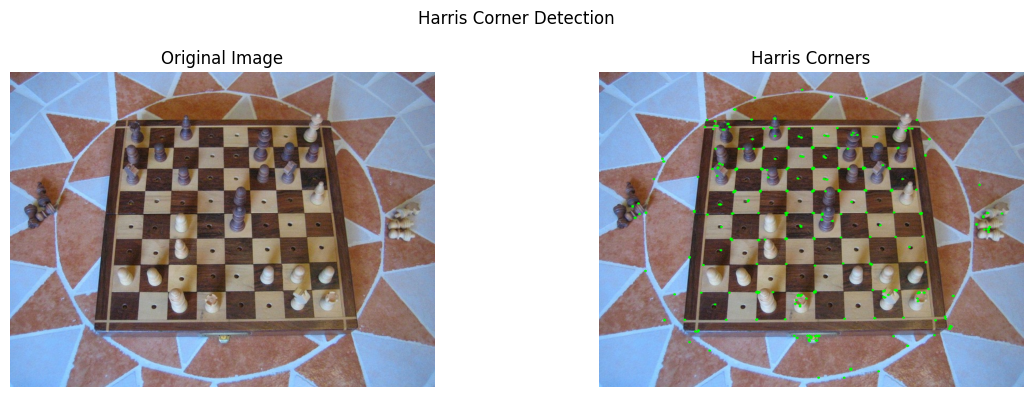

In [13]:
def plot_corners(img: npt.NDArray[np.uint8], corners: npt.NDArray[float]) -> npt.NDArray[np.uint8]:
    """ Plots corners onto an image. """

    corners = cv2.dilate(corners, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    img_corners = img.copy()
    img_corners[corners > 0.025 * corners.max()] = [0, 255, 0]
    return img_corners

def detect_corners(img: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """ Detect and highlight circles using the Harris Corner Detector. """

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Corner detection
    corners = cv2.cornerHarris(img_gray, blockSize=2, ksize=3, k=0.15)

    # Highlight circles
    img_corners = plot_corners(img, corners)

    # Plot transformations
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Harris Corner Detection')

    display_image(img, 'Original Image', axs[0])
    display_image(img_corners, 'Harris Corners', axs[1])

    plt.tight_layout()
    save_plot(f'{PLOTS_DIR}/harris_corner_detection.png')

    return img_corners

chessboard = read_image(f'{IMAGES_DIR}/chessboard.jpg')
chessboard_corners = detect_corners(chessboard)
write_image(f'{OUTPUT_DIR}/chessboard.png', chessboard_corners)

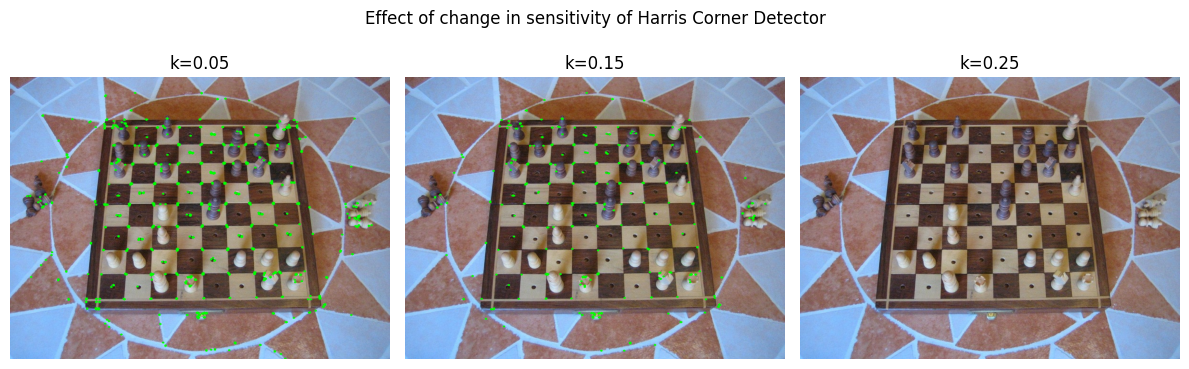

In [14]:
chessboard = read_image(f'{IMAGES_DIR}/chessboard.jpg')
chessboard_gray = cv2.cvtColor(chessboard, cv2.COLOR_RGB2GRAY)
cv2.cornerHarris(chessboard_gray, blockSize=2, ksize=3, k=0.04)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Effect of change in sensitivity of Harris Corner Detector')

display_image(plot_corners(chessboard, cv2.cornerHarris(chessboard_gray, blockSize=2, ksize=3, k=0.05)), 'k=0.05', axs[0])
display_image(plot_corners(chessboard, cv2.cornerHarris(chessboard_gray, blockSize=2, ksize=3, k=0.15)), 'k=0.15', axs[1])
display_image(plot_corners(chessboard, cv2.cornerHarris(chessboard_gray, blockSize=2, ksize=3, k=0.3)), 'k=0.25', axs[2])

plt.tight_layout()
save_plot(f'{PLOTS_DIR}/harris_corner_detection_parameters.png')

**Observations:**

- More corners were captured for lower value of sensitivity parameter k. This includes the corners in the triangles on the floor.

- This can be interpreted as increase in recall, and decrease in precision.

### Question 5

- The Hough Transform for lines uses the two-dimensional space, $(\rho, \theta)$. The set of all straight lines passing through a point in the image space corresponds to a sinusoidal curve in the transformed space. The problem of finding straight lines or detecting collinear points is thus converted to the problem of finding concurrent curves.

- The Hough Transform for circles uses a three-dimensional parameter space, $(x, y, r)$, representing the circle's center coordinates and radius. Each edge point votes for all potential circle centers and radii, resulting in a more intensive search. We thus notice a drastic increase in computational complexity, especially when an expected range for radius is not known in advance.